# Logistic Regression
In this notebook we'll import our cleaned data and run a Logistic Regression.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import visualizations
%matplotlib inline

Import our dataframe and run a basic Logistic Regression model with 

In [3]:
df = pd.read_csv('in-vehicle-coupon-recommendation_cleaned.csv', index_col=[0])

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1989)

In [174]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)
train_predictions = logmodel.predict(X_train)

Let's take a look at the results below.  On the left is our Confusion Matrix.  This show's us how many of our predictions were correct or incorrect.  On the right is our classificaiton report.  As we go through and compare our models, it is important to understand which metric we would be most interested in maximizing. That would depend on the purpose of this analysis.

1. Focusing on accuracy will maximixe the percentage of accurate vs. non-accurate predictions.
2. Focusing on recall will minmimize the number of people that would accept the coupon that were not offered it (false neg).
3. Focusing on precision will minimize the number of people that would not accept the coupon that were offered it (false pos).

Since this is an excercise in prediction, we'll focus on accuracy.

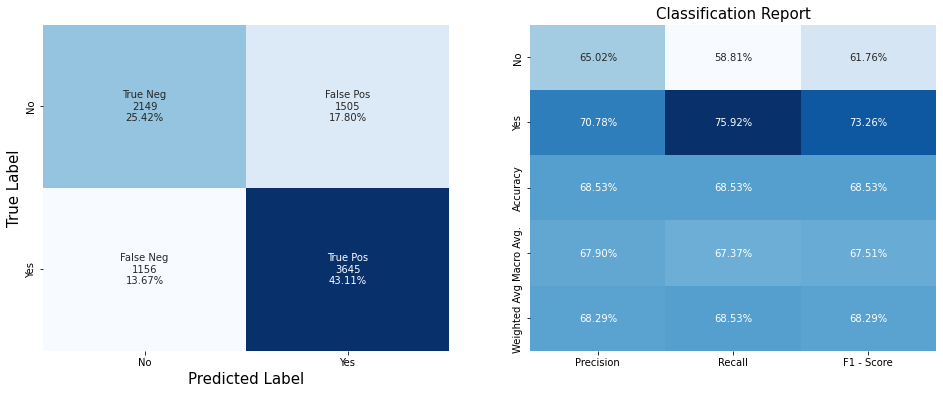

In [5]:
# created visualizations for reviewing Classification Report and Confusion Matrix
import visualizations
visualizations.class_results(y_train, train_predictions)

### Feature Selection - XGBoost
Let's go ahead and do some feature selection to see if we can pare down our model a little bit.  The first thing we will use is XGBoost to determine which features are most important in our model.

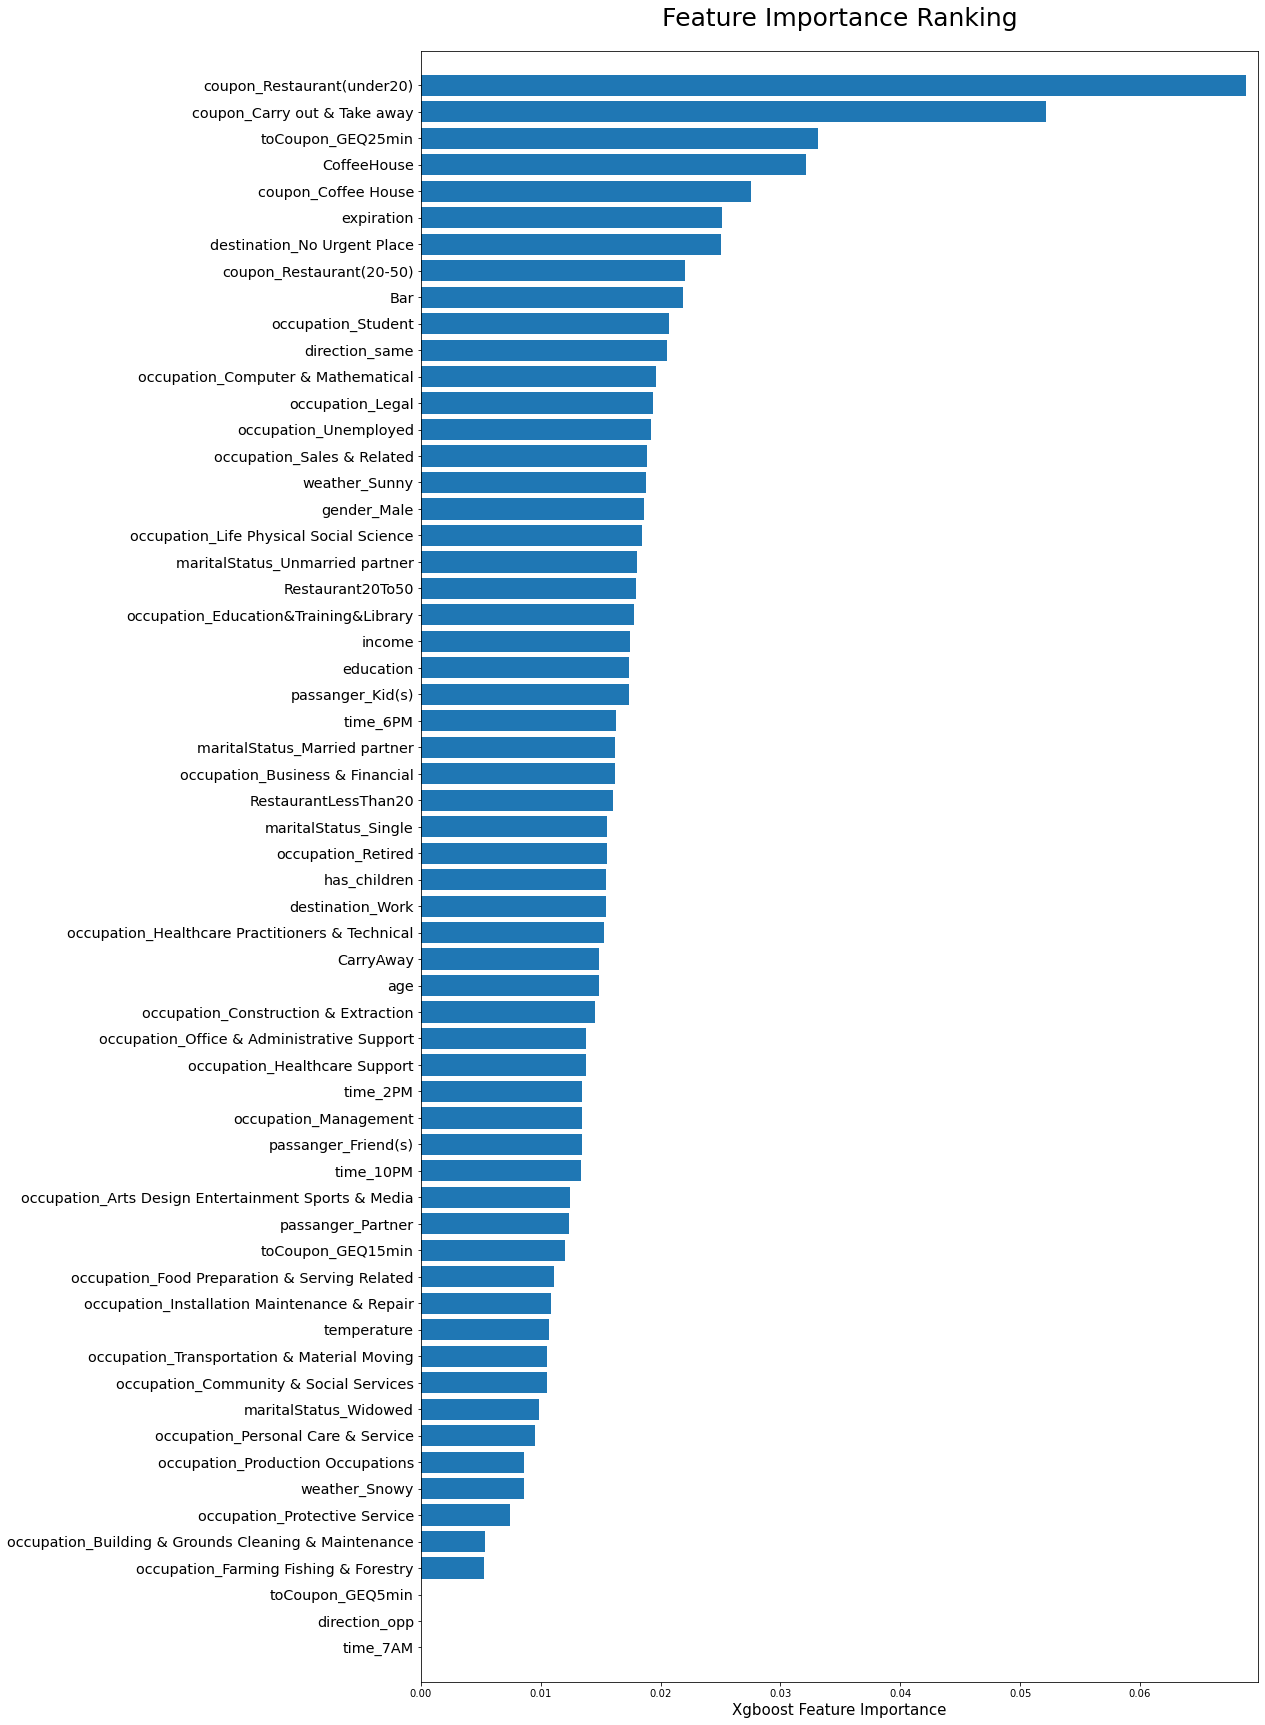

In [35]:
#XGBoost doesn't like "<" symbol
X_train_ = X_train.rename(columns={'coupon_Restaurant(<20)':'coupon_Restaurant(under20)'})

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train_, y_train_encoded)

sorted_idx = xgb.feature_importances_.argsort()
plt.figure(figsize=(15,30))
plt.barh(X_train_.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance", size=15)
plt.yticks(size='x-large')
plt.title('Feature Importance Ranking', pad=25, size=25)
plt.margins(0.015, tight=True)
plt.show()

Now we will do an iterative model where we look at recall selecting one additional feature at a time, using the rankings above.

In [176]:
xgb = XGBClassifier(n_estimators=100, eval_metric='error', use_label_encoder=False)
xgb.fit(X_train_, y_train_encoded)
features = xgb.feature_importances_.argsort()[::-1]
xgb_accuracy =[]

for i in range(1,len(X_train_.columns)+1):
    logmodel = LogisticRegression(max_iter=1000)
    feature_list = features[0:i]
    columns = X_train_.columns[feature_list]  
    logmodel.fit(X_train_[columns], y_train_encoded)
    train_predictions = logmodel.predict(X_train_[columns])
    recall = metrics.accuracy_score(y_train_encoded, train_predictions)
    xgb_accuracy.append([i, columns, recall])

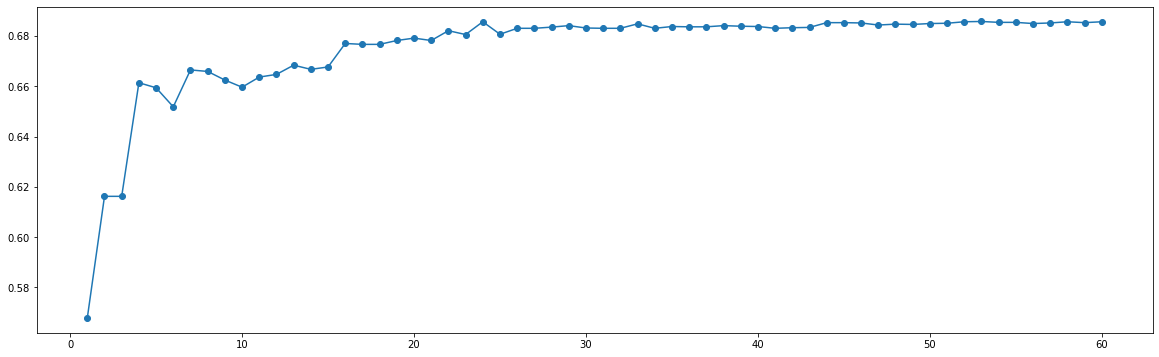

In [177]:
xgb_accuracy = pd.DataFrame(xgb_accuracy, columns=['Number of Features', 'Features', 'Accuracy'])
plt.figure(figsize=(20,6))
plt.plot(xgb_recall['Number of Features'], xgb_accuracy['Accuracy'], marker='o')
plt.show()

It seems that our accuracy on our training data starts to flatten out at about 16 features and is maximized with 24 features. 

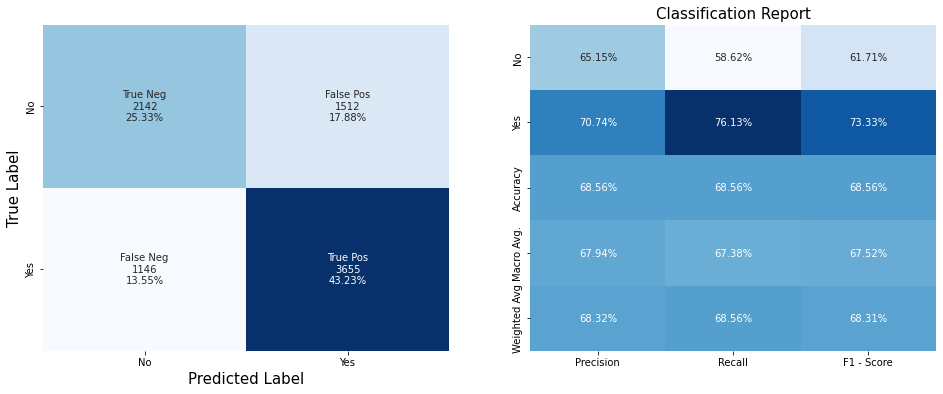

In [184]:
logmodel = LogisticRegression(max_iter=1000)
feature_list = features[0:24]
columns = X_train_.columns[feature_list]  
logmodel.fit(X_train_[columns], y_train_encoded)
train_predictions = logmodel.predict(X_train_[columns])
visualizations.class_results(y_train, train_predictions)

In [116]:
# Capture Features
features_XGB = pd.DataFrame(X_train_.columns[np.flip(xgb.feature_importances_.argsort()[-24:])], columns=['Feature'])
features_XGB.set_index('Feature', inplace=True)
features_XGB['XGBoost'] = 1

### Feature Selection - Recursive Feature Elimination
An alternative way to determine features would be to do a Recursive Feature Elimination.

In [68]:
from sklearn.feature_selection import RFE

accuracy_features = []

for i in range(1, len(X_train.columns)+1):
    logmodel = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator=logmodel, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    features = X_train.columns[rfe.support_]
    logmodel.fit(X_train[features], y_train)
    train_predictions = logmodel.predict(X_train[features])
    accuracy = metrics.accuracy_score(y_train, train_predictions)
    accuracy_features.append([i, features, accuracy])

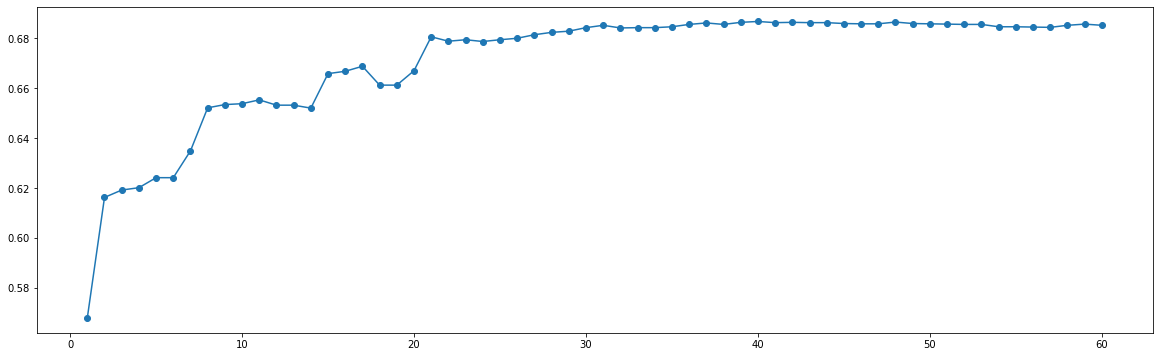

In [69]:
accuracy_features = pd.DataFrame(accuracy_features, columns=['Number of Features', 'Features', 'Accuracy'])
plt.figure(figsize=(20,6))
plt.plot(accuracy_features['Number of Features'], accuracy_features['Accuracy'], marker='o')
plt.show()

Under RFE accuracy on our training data starts to flatten out at about 21 features. 

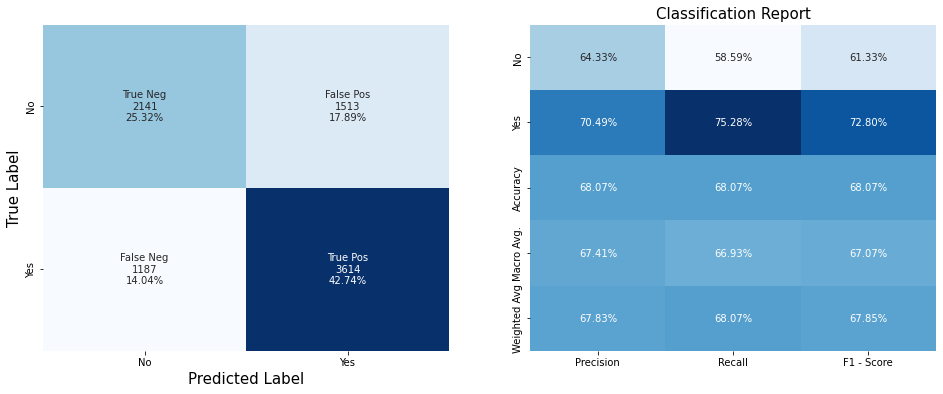

In [185]:
logmodel = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=logmodel, n_features_to_select=21)
rfe.fit(X_train, y_train)
features = X_train.columns[rfe.support_]
logmodel.fit(X_train[features], y_train)
train_predictions = logmodel.predict(X_train[features])
visualizations.class_results(y_train, train_predictions)

In [115]:
# Capture Features
features_RFE = pd.DataFrame(X_train.columns[rfe.support_], columns=['Feature'])
features_RFE.set_index('Feature', inplace=True)
features_RFE['RFE'] = 1

### Feature Selection - SelectKBest
Another way to do feature selection, would be to use SelectKBest.

In [74]:
from sklearn.feature_selection import SelectKBest, chi2

num_features = []

for i in range(1,61):
    features = np.array(X_train.columns)
    select = SelectKBest(score_func=chi2, k=i)
    z = select.fit_transform(X_train, y_train)
    filters = select.get_support()
    features = features[filters]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train[features], y_train)
    predictions = model.predict(X_train[features])
    accuracy = metrics.accuracy_score(y_train, predictions)
    precision = metrics.precision_score(y_train, predictions)
    recall = metrics.recall_score(y_train, predictions)
    f1 = metrics.f1_score(y_train, predictions)
    num_features.append([i, features, accuracy, precision, recall, f1])

num_features = pd.DataFrame(num_features, columns=['Number of Features', 'Features', 'Accuracy', 
                                                   'Precision', 'Recall', 'F1-Score'])

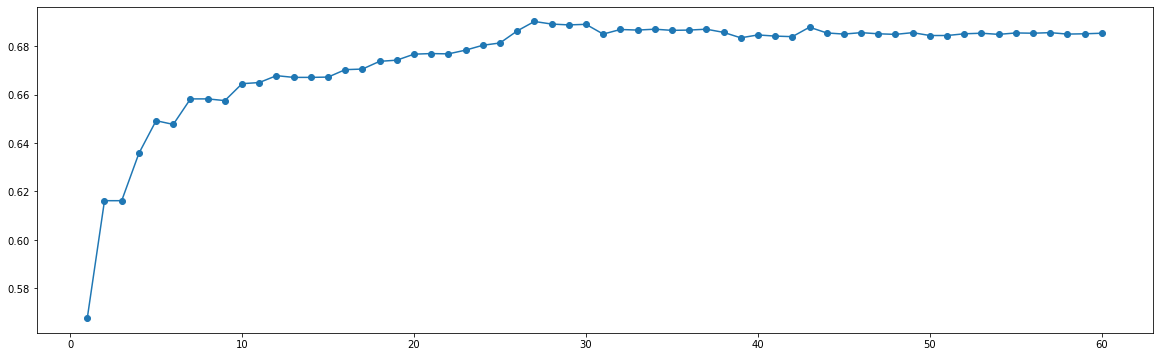

In [75]:
plt.figure(figsize=(20,6))
plt.plot(num_features['Number of Features'], num_features['Accuracy'], marker='o')
plt.show()

SelectKBest both see to flatten out and peak at 27 features.  Let's take a look at what those features are.

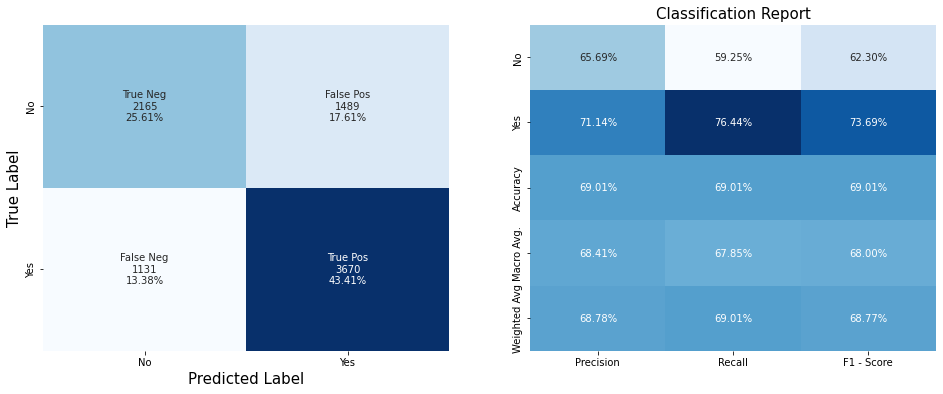

In [190]:
features = np.array(X_train.columns)
select = SelectKBest(score_func=chi2, k=27)
z = select.fit_transform(X_train, y_train)
filters = select.get_support()
features = features[filters]

model = LogisticRegression(max_iter=1000)
model.fit(X_train[features], y_train)
train_predictions = model.predict(X_train[features])
visualizations.class_results(y_train, train_predictions)

In [117]:
features = np.array(X_train.columns)
select = SelectKBest(score_func=chi2, k=26)
z = select.fit_transform(X_train, y_train)
filters = select.get_support()
features = features[filters]

In [122]:
# Capture Features
features_SelectKBest = pd.DataFrame(features, columns=['Feature'])
features_SelectKBest.set_index('Feature', inplace=True)
features_SelectKBest['SelectKBest'] = 1

### Comparison of Feature Selection Models
Whether we use XGBoost, RFE, or SelectKBest, our accuracy rate seems to top out at about 68-69%, which is the same range as our intial model with all features.  It is worth asking then, should we limit our features at all?  Let's take a look at the comparison of our features

In [173]:
feature_selection = features_XGB
feature_selection = feature_selection.join(features_RFE, how='outer')
feature_selection = feature_selection.join(features_SelectKBest, how='outer')
feature_selection = feature_selection.fillna(0)

feature_selection['Totals'] = feature_selection['XGBoost'] + feature_selection['RFE'] + feature_selection['SelectKBest']
feature_selection.sort_values('Totals', ascending=False)

,XGBoost,RFE,SelectKBest,Totals
Feature,,,,
weather_Sunny,1.0,1.0,1.0,3.0
expiration,1.0,1.0,1.0,3.0
coupon_Carry out & Take away,1.0,1.0,1.0,3.0
coupon_Coffee House,1.0,1.0,1.0,3.0
coupon_Restaurant(20-50),1.0,1.0,1.0,3.0
destination_No Urgent Place,1.0,1.0,1.0,3.0
CoffeeHouse,1.0,1.0,1.0,3.0
toCoupon_GEQ25min,1.0,0.0,1.0,2.0
passanger_Kid(s),1.0,1.0,0.0,2.0


Well, we have a lot of data here. So, we now have to answer the question, which features to select.  The way I see it, we have a few options:
1.  We could use the results of one of our feature selection models
2.  We could use all our features
3.  We could select features based on a combination of our feature selection models.

Since false positives and false negatives are not always the best way to look at a models ability to make predictions, it is useful to look at the 

Reciver Operating Characteristic (ROC) curve graphs True Positive Rate vs. False Positive Rate at different classification thresholds (0 - 100%).  The Area Under the Curve (AUC) gives us a guage of the model performance.  Our AUC is 67%.

The Cumulative Accuracy Profile (CAP) is another way to measure our model's performance.  The CAP tries to analyze how to effectively identify all data points of a calls using a minimum number of tries.  We compare our model's performance vs. a random model and a perfect model.

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# for ROC curve
logit_roc_auc = roc_auc_score(y_test, test_predictions)
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])

# for CAP
total = len(y_test)
class_1_count = np.sum(y_test)
class_0_count = total - class_1_count

#Trained Model
probs = logmodel.predict_proba(X_test)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, y_test), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)

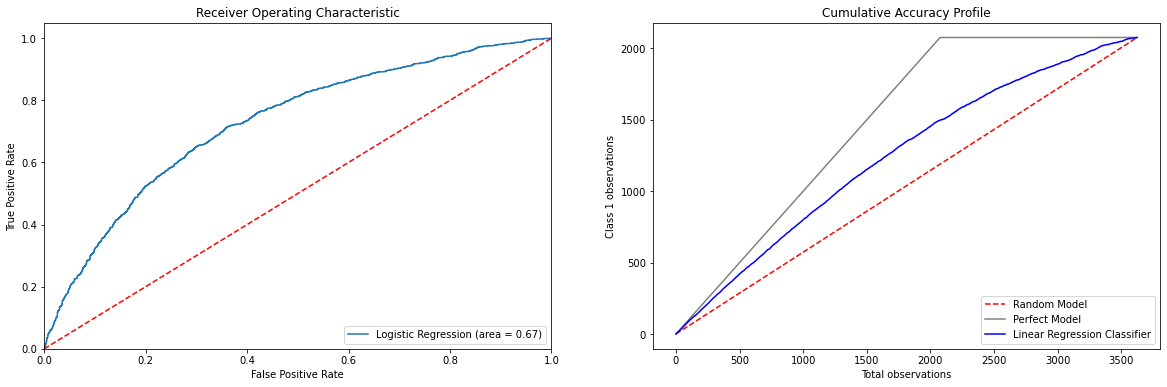

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

# plot ROC
axs[0].plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
axs[0].plot([0, 1], [0, 1],'r--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")
#Random model
axs[1].plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
#Perfect Model
axs[1].plot([0, class_1_count, total], [0, class_1_count, class_1_count], c = 'grey', label = 'Perfect Model')
#CAP Curve
axs[1].plot(x_values, y_values, c = 'b', label = 'Linear Regression Classifier')
axs[1].set_title('Cumulative Accuracy Profile')
axs[1].set_xlabel('Total observations')
axs[1].set_ylabel('Class 1 observations')
axs[1].legend(loc = 'lower right')

plt.show()

When looking at CAP, we can calculate the performance of our model as a percentage of the difference between the performance of the perfect and random model. In our case, that number is 45%.

In [8]:
# Area under Random Model
a = metrics.auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = metrics.auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = metrics.auc(x_values, y_values) - a

print("Accuracy Rate for Logistic Regression Classifier: {:.2%}".format(aR / aP))

Accuracy Rate for Logistic Regression Classifier: 45.33%


In [74]:
# xgb_features = xgb_recall.loc[3][1]
# logmodel = LogisticRegression(max_iter=1000)
# logmodel.fit(X_train_[xgb_features], y_train)
# train_predictions = logmodel.predict(X_train_[xgb_features])
# print(X_train_['coupon_Restaurant(under20)'].sum())
# print(train_predictions.sum())
# print(len(X_train))

1851
5586
8455


We can also use Recurssive Feature Elimination

In [76]:
from sklearn.feature_selection import SelectKBest, chi2

num_features = []

for i in range(1,61):
    features = np.array(X_train.columns)
    select = SelectKBest(score_func=chi2, k=i)
    z = select.fit_transform(X_train, y_train)
    filters = select.get_support()
    features = features[filters]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train[features], y_train)
    predictions = model.predict(X_train[features])
    accuracy = metrics.accuracy_score(y_train, predictions)
    precision = metrics.precision_score(y_train, predictions)
    recall = metrics.recall_score(y_train, predictions)
    f1 = metrics.f1_score(y_train, predictions)
    num_features.append([i, features, accuracy, precision, recall, f1])

num_features = pd.DataFrame(num_features, columns=['Number of Features', 'Features', 'Accuracy', 
                                                   'Precision', 'Recall', 'F1-Score'])

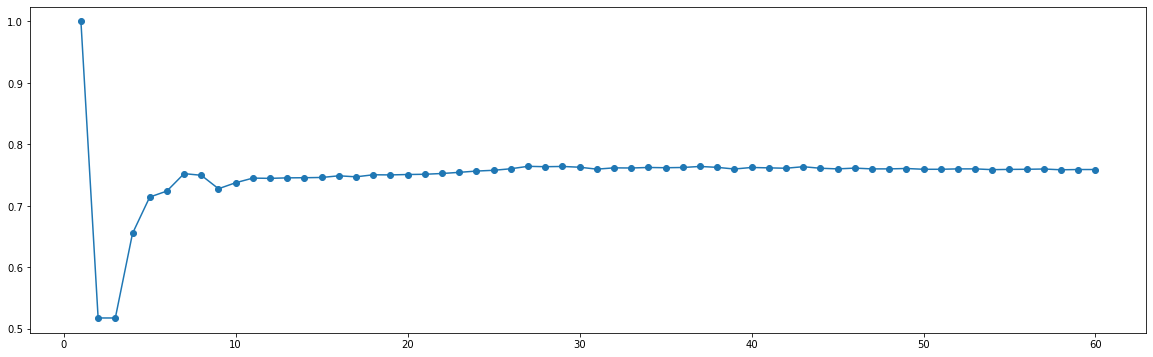

In [78]:
from sklearn.feature_selection import RFE

KeyboardInterrupt: 

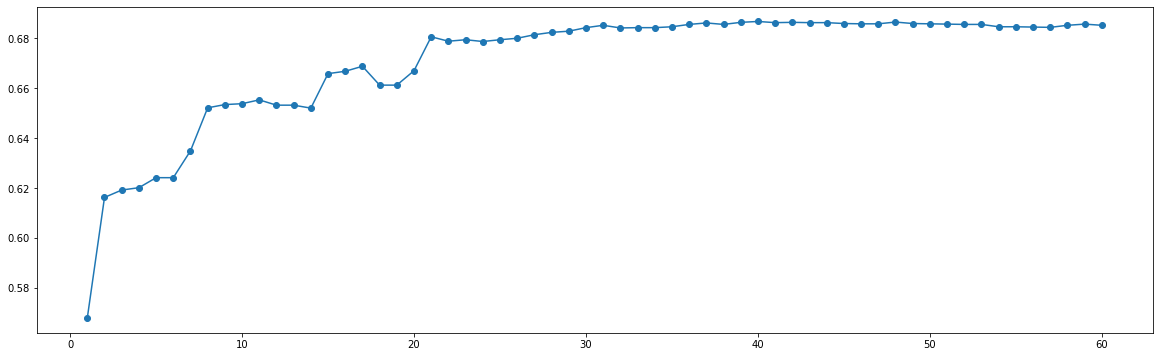

In [31]:
accuracy_features = pd.DataFrame(accuracy_features, columns=['Number of Features', 'Features', 'Accuracy'])
plt.figure(figsize=(20,6))
plt.plot(accuracy_features['Number of Features'], accuracy_features['Accuracy'], marker='o')
plt.show()

### Hyperparameter Optimization
Now we can take a look at some of the hyperparameters of our Logistic Regression Model and refine and tune those.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
logmodel = LogisticRegression(max_iter=1000)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict()
param_grid['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
param_grid['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(logmodel, param_grid, scoring='recall', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [142]:
df = pd.read_csv('in-vehicle-coupon-recommendation_cleaned.csv', index_col=[0])
X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1989)